In [31]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [7]:
df_train = pd.read_csv('../data/Models/btc_train.csv', index_col='date')
df_test = pd.read_csv('../data/Models/btc_test.csv', index_col='date')
df_train.index = pd.to_datetime(df_train.index)
df_test.index = pd.to_datetime(df_test.index)

In [11]:
df = pd.concat([df_train, df_test])

In [12]:
X = df.drop(columns=['log_returns'])
y = df['log_returns']

In [13]:
def xgb_cv(learning_rate, max_depth, subsample, colsample_bytree, reg_alpha, reg_lambda, min_child_weight, gamma, n_estimators):
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'min_child_weight': int(min_child_weight),
        'gamma': gamma,
        'n_estimators': int(n_estimators),
        'objective': 'reg:squarederror',
        'random_state': 1
    }

    
    model = xgb.XGBRegressor(**params)
    cv_results = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1)
    return np.mean(cv_results)

In [14]:
pbounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (1, 6),
    'subsample': (0.4, 0.9),
    'colsample_bytree': (0.4, 0.9),
    'reg_alpha': (0, 5),
    'reg_lambda': (0, 5),
    'min_child_weight': (1, 10),
    'gamma': (0, 5),
    'n_estimators': (50, 300)
}

In [15]:
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)

In [16]:
optimizer.maximize(init_points=25, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.004451 | 0.6085    | 3.602     | 0.01003   | 2.512     | 2.321     | 73.08     | 0.9313    | 1.728     | 0.5984    |
| 2         | -0.00445  | 0.6694    | 2.096     | 0.2087    | 2.022     | 8.903     | 56.85     | 3.352     | 2.087     | 0.6793    |
| 3         | -0.00445  | 0.4702    | 0.9905    | 0.2422    | 5.841     | 3.821     | 223.1     | 4.382     | 4.473     | 0.4425    |
| 4         | -0.00445  | 0.4195    | 0.8492    | 0.2647    | 1.492     | 4.79      | 289.5     | 2.666     | 3.459     | 0.5578    |
| 5         | -0.00445  | 0.7433    | 4.173     | 0.0153    | 4.751     | 9.9       | 237.0     | 1.402     | 3.946     | 0.4516    |
| 6         | -0.00445  | 0.6239    | 4.543     | 0.09515   | 

In [17]:
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['n_estimators'] = int(best_params['n_estimators'])

In [18]:
print("Mejores parámetros encontrados:", best_params)

Mejores parámetros encontrados: {'colsample_bytree': 0.4143976970692235, 'gamma': 1.0532657148694813, 'learning_rate': 0.20889025145158435, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 234, 'reg_alpha': 0.5086335844158713, 'reg_lambda': 4.660649085069025, 'subsample': 0.6577296758282312}


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=1)

In [22]:
best_model = XGBRegressor(
    colsample_bytree=0.4144,
    gamma=1.0533,
    learning_rate=0.2089,
    max_depth=4,
    min_child_weight=9,
    n_estimators=234,
    reg_alpha=0.5086,
    reg_lambda=4.6606,
    subsample=0.6577,
    objective="reg:squarederror",
    random_state=1
)

In [23]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4144, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0533, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2089, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=234, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [24]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [25]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [26]:
print(f'Train: MAE: {mae_train}, RMSE: {rmse_train}, R2: {r2_train}')
print(f'Test: MAE: {mae_test}, RMSE: {rmse_test}, R2: {r2_test}')

Train: MAE: 0.016323541448860453, RMSE: 0.021769169945470006, R2: -2.5081277965632864e-07
Test: MAE: 0.01684804056291747, RMSE: 0.021732657580478914, R2: -0.0019827076037821634


In [27]:
best_params_gs = {
    'colsample_bytree': 0.7,
    'gamma': 0,
    'learning_rate': 0.03,
    'max_depth': 2,
    'min_child_weight': 3,
    'n_estimators': 200,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'subsample': 0.7
}

In [28]:
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1, **best_params_gs)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [29]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [30]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train: MAE: {mae_train}, RMSE: {rmse_train}, R2: {r2_train}")
print(f"Test: MAE: {mae_test}, RMSE: {rmse_test}, R2: {r2_test}")

Train: MAE: 0.0008708048067062333, RMSE: 0.0018419385855257295, R2: 0.9928407642986018
Test: MAE: 0.0008665466781288853, RMSE: 0.001749950396277598, R2: 0.9935034014820587


In [33]:
residuals = y_test - y_pred_test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


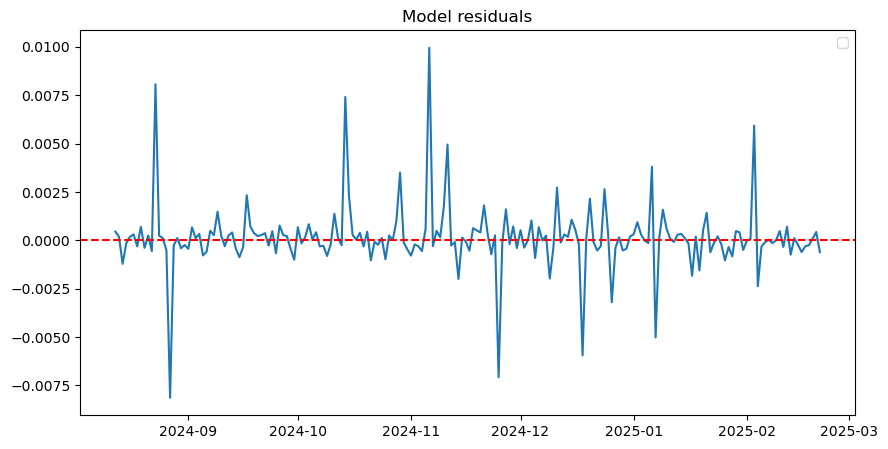

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Model residuals')
plt.legend()
plt.show()

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


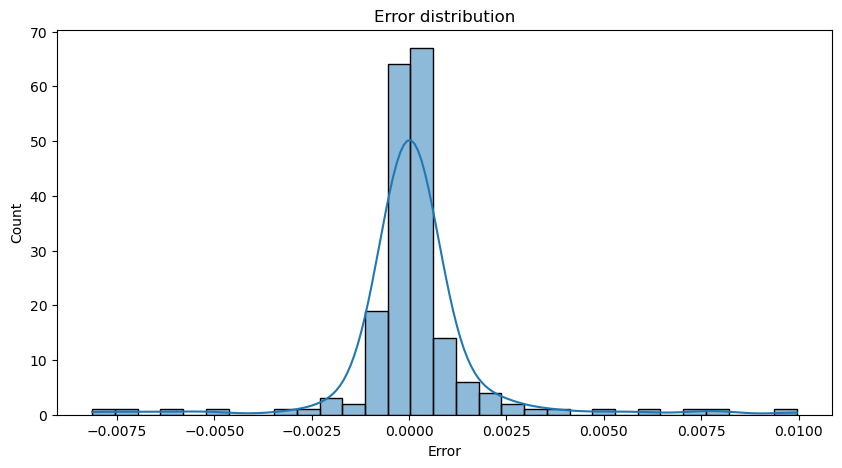

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals,bins=31, kde=True)
plt.title('Error distribution')
plt.xlabel('Error')
plt.show()

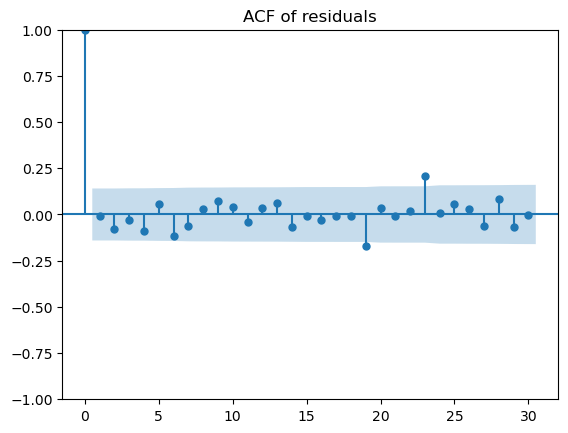

In [36]:
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.title('ACF of residuals')
plt.show()

In [185]:
import joblib
joblib.dump(model, "xgboost_btc_model.pkl")

['xgboost_btc_model.pkl']

In [178]:
from binance.client import Client
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

# Cargar API Keys desde el .env
load_dotenv()
BINANCE_API_KEY = os.getenv("BINANCE_API_KEY")
BINANCE_API_SECRET = os.getenv("BINANCE_API_SECRET")

# Inicializar cliente de Binance
client = Client(BINANCE_API_KEY, BINANCE_API_SECRET)

# Función para extraer datos de Binance
def fetch_binance_data(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY, limits=50):
    """ Extrae datos históricos de Binance """
    klines = client.get_klines(symbol=symbol, interval=interval, limit=limits)
    df = pd.DataFrame(klines, columns=["date", "open", "high", "low", "close", "volume",
                                       "close_time", "quote_asset_volume", "trades",
                                       "taker_buy_base", "taker_buy_quote", "ignore"])
    df["date"] = pd.to_datetime(df["date"], unit="ms")  # Mantener como datetime
    df[["close", "volume"]] = df[["close", "volume"]].astype(float)  # Convertir solo estas columnas
    return df[["date", "close", "volume"]]  # Retornar solo las necesarias


# Calcular las features necesarias
def create_features(df):
    """ Genera las mismas features que usaste en el modelo """
    df["returns"] = df["close"].pct_change()
    df["square_returns"] = df["returns"] ** 2
    df["abs_returns"] = df["returns"].abs()
    df["returns_2"] = df["returns"].shift(1)  # Retorno del día anterior

    df["vol_ratio7"] = df["volume"] / df["volume"].rolling(7).mean()
    df["vol_ratio14"] = df["volume"] / df["volume"].rolling(14).mean()
    df["vol_ratio30"] = df["volume"] / df["volume"].rolling(30).mean()

    df["cumulative_returns"] = (1 + df["returns"]).cumprod()
    df["rolling_volatility_7"] = df["returns"].rolling(7).std()

    df.dropna(inplace=True)  # Eliminar filas con NaN generados por rolling()
    return df

In [179]:

# Obtener datos y generar features
btc_data = fetch_binance_data()
btc_data

,date,close,volume
0,2025-01-07,96954.61,32059.875370
1,2025-01-08,95060.61,33704.678940
2,2025-01-09,92552.49,34544.836850
3,2025-01-10,94726.11,31482.864240
4,2025-01-11,94599.99,7047.904300
5,2025-01-12,94545.06,8606.866220
6,2025-01-13,94536.10,42619.564230
7,2025-01-14,96560.86,27846.617530
8,2025-01-15,100497.35,30509.991790
9,2025-01-16,99987.30,27832.853170


In [180]:

btc_data = create_features(btc_data)
btc_data

,date,close,volume,returns,square_returns,abs_returns,returns_2,vol_ratio7,vol_ratio14,vol_ratio30,cumulative_returns,rolling_volatility_7
29,2025-02-05,96612.43,26233.30444,-0.011770,1.385396e-04,0.011770,-0.035186,0.798635,0.869655,0.817097,0.996471,0.025186
30,2025-02-06,96554.35,23515.20405,-0.000601,3.613992e-07,0.000601,-0.011770,0.703221,0.840098,0.738992,0.995872,0.024156
31,2025-02-07,96506.80,31794.22065,-0.000492,2.425255e-07,0.000492,-0.000601,0.912556,1.112632,1.001173,0.995381,0.023943
32,2025-02-08,96444.74,10147.24294,-0.000643,4.135307e-07,0.000643,-0.000492,0.293828,0.354146,0.327926,0.994741,0.023700
33,2025-02-09,96462.75,14120.91613,0.000187,3.487148e-08,0.000187,-0.000643,0.446776,0.487592,0.465039,0.994927,0.021362
34,2025-02-10,97430.82,20572.87537,0.010036,1.007150e-04,0.010036,0.000187,0.864138,0.767519,0.667607,1.004912,0.014531
35,2025-02-11,95778.20,18647.76379,-0.016962,2.877089e-04,0.016962,0.010036,0.900041,0.702010,0.598634,0.987866,0.008845
36,2025-02-12,97869.99,29151.16625,0.021840,4.769829e-04,0.021840,-0.016962,1.379243,1.080007,0.949501,1.009441,0.011839
37,2025-02-13,96608.14,19921.77616,-0.012893,1.662327e-04,0.012893,0.021840,0.966032,0.737004,0.654516,0.996426,0.013116
38,2025-02-14,97500.48,18173.02646,0.009237,8.531655e-05,0.009237,-0.012893,0.973048,0.679147,0.605239,1.005630,0.013545


In [181]:
btc_data.columns 

Index(['date', 'close', 'volume', 'returns', 'square_returns', 'abs_returns',
       'returns_2', 'vol_ratio7', 'vol_ratio14', 'vol_ratio30',
       'cumulative_returns', 'rolling_volatility_7'],
      dtype='object')

In [183]:
# Seleccionar el día 2025-02-22 como input para la predicción
latest_data = btc_data.loc[btc_data["date"].dt.date == pd.to_datetime("2025-02-22").date(), 
                           ["close", "returns", "square_returns", "abs_returns",
                            "returns_2", "vol_ratio7", "vol_ratio14", "vol_ratio30",
                            "cumulative_returns", "rolling_volatility_7"]]

# Asegurarnos de que latest_data no esté vacío
if latest_data.empty:
    raise ValueError("No se encontraron datos para 2025-02-22. Verifica el formato de la fecha.")

# Obtener el precio real del día siguiente (2025-02-23)
real_price = btc_data.loc[btc_data["date"].dt.date == pd.to_datetime("2025-02-23").date(), "close"]

# Asegurarnos de que real_price tenga un valor
if real_price.empty:
    raise ValueError("No se encontró el precio real de BTC para 2025-02-23.")

real_price = real_price.values[0]  # Extraer el valor numérico

# Asegurar que latest_data tenga la forma correcta
latest_data = latest_data.iloc[-1:].copy()  # Tomar la última fila como DataFrame
latest_data.columns = model.feature_names_in_  # Asegurar que las columnas coincidan

# Hacer la predicción
prediction = model.predict(latest_data)[0]

# Mostrar resultados
print(f"Predicción del precio de BTC para 2025-02-23: {prediction}")
print(f"Precio real de BTC el 2025-02-23: {real_price}")
print(f"Diferencia: {real_price - prediction}")


Predicción del precio de BTC para 2025-02-23: 0.003827507607638836
Precio real de BTC el 2025-02-23: 96258.0
Diferencia: 96257.99617249239


In [184]:
import numpy as np

# Obtener el precio de cierre del día anterior
previous_close = btc_data.loc[btc_data["date"].dt.date == pd.to_datetime("2025-02-22").date(), "close"].values[0]

# Convertir la predicción de log-return a precio de cierre
predicted_price = previous_close * np.exp(prediction)

# Mostrar resultados con conversión
print(f"Predicción del precio de BTC para 2025-02-23 (log-return): {prediction}")
print(f"Predicción del precio de BTC para 2025-02-23 (convertido a cierre): {predicted_price}")
print(f"Precio real de BTC el 2025-02-23: {real_price}")
print(f"Diferencia: {real_price - predicted_price}")


Predicción del precio de BTC para 2025-02-23 (log-return): 0.003827507607638836
Predicción del precio de BTC para 2025-02-23 (convertido a cierre): 96921.26802620529
Precio real de BTC el 2025-02-23: 96258.0
Diferencia: -663.2680262052891
